# Linear Regression Practice #1

### [Experience vs Salary Dataset](https://www.kaggle.com/datasets/saquib7hussain/experience-salary-dataset)

This dataset describes the relationship between months of experience and monthly salary (in thousands of dollars).

Some use cases this model could be helpful for:


*   Somebody preparing to negotiate their salary looking for an idea of what they should ask for
*   An employer creating a job listing who needs to decide a good salary for the experience level they are looking to hire
*   An employer creating a job listing who wants to understand how much experience they can reasonably expect to hire based on their budget of what salary they can afford to pay that new employee




## 0. Initial setup

In [1]:
# Import libraries
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# Make our code device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Load the dataset and visualize it

Number of records: 1000


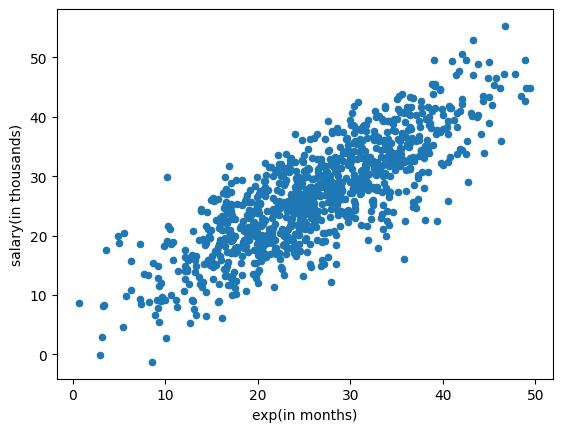

In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Datasets/Experience-Salary.csv")

print(f"Number of records: {len(df)}")

df.plot(kind="scatter", x="exp(in months)", y="salary(in thousands)")
plt.show()

## 2. Split the data into training and testing sets

Visualize the training and testing data to see the distribution of the testing records

Size of training set: 800
Size of testing set: 200


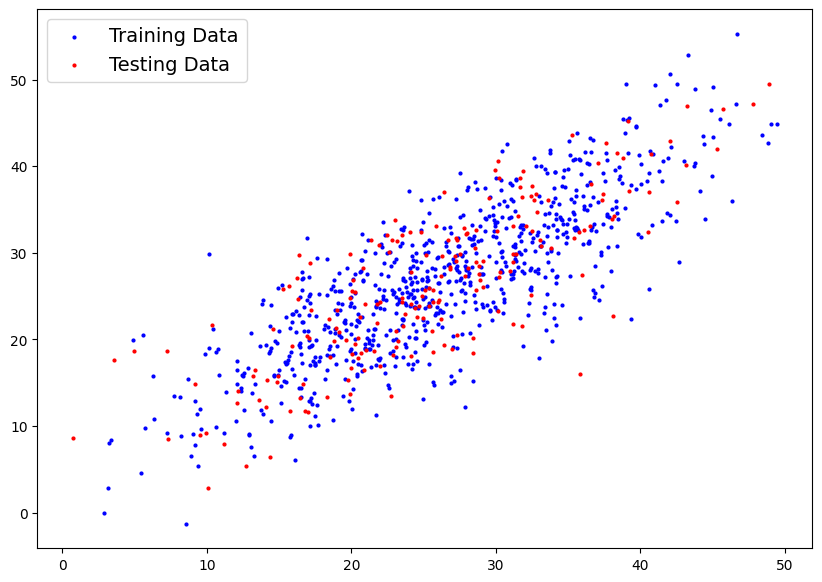

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["exp(in months)"], df["salary(in thousands)"], test_size=0.2)
X_train = torch.tensor(X_train.values).float().unsqueeze(dim=1)
X_test = torch.tensor(X_test.values).float().unsqueeze(dim=1)
y_train = torch.tensor(y_train.values).float().unsqueeze(dim=1)
y_test = torch.tensor(y_test.values).float().unsqueeze(dim=1)

print(f"Size of training set: {len(X_train)}")
print(f"Size of testing set: {len(X_test)}")

plt.figure(figsize=(10, 7))

plt.scatter(X_train, y_train, c="b", s=4, label="Training Data")
plt.scatter(X_test, y_test, c="r", s=4, label="Testing Data")

plt.legend(prop={"size": 14})

## 3. Build a Linear Regression model

This model consists of one linear layer with one input feature (experience) and one output feature (salary)

In [5]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1) # Initialize a linear layer with 1 input for experience and 1 output for salary

  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is a value for experience
    return self.linear_layer(x) # Compute the linear regression formula: salary = weight * x + bias

Initialize the model and print the starting values for weight and bias

In [6]:
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.2585]])),
              ('linear_layer.bias', tensor([0.5846]))]))

## 4. Select a loss function and optimizer

The loss function calculates the error between our model's predictions and the ground truth labels. L1 loss returns the mean of the errors across all points in our training data.

The optimizer updates the values of our model's parameters (weight and bias) according to the result of the loss function. We will use stochastic graident descent, which aims to reduce the loss with each training iteration.

In [7]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

## 5. Create a training/testing loop

The training loop uses the loss function and optimizer to find the optimal values of the model's parameters. It runs for many iterations, called epochs, until the change in loss between epochs is marginal. We can also test the model as we train it by predicting on the testing dataset occasionally.

In [8]:
epochs = 10

train_losses = []

for epoch in range(epochs):
  model.train() # Sets the model into training mode, which changes some behaviors as opposed to evaluation mode

  y_pred = model(X_train) # Forward pass on the training dataset - runs the forward() method on all input values (months of experience) in the training dataset, predicts an output using the current parameters (weight and bias)

  loss = loss_fn(y_pred, y_train) # Calculate the loss by comparing the predictions and the ground truth labels
  train_losses.append(loss.detach().numpy())

  optimizer.zero_grad() # Reset the optimizer's gradients so they are calculated for this epoch individually, instead of accumulating across epochs as would happen without calling zero_grad()

  loss.backward() # Compute the gradient for each of the model's parameters. This determines how much each parameter should be adjusted

  optimizer.step() # Adjust the values of the parameters

## 6. Make predictions on the testing dataset with the trained model

Since we are using linear regression, our model will attempt to find a line of best fit

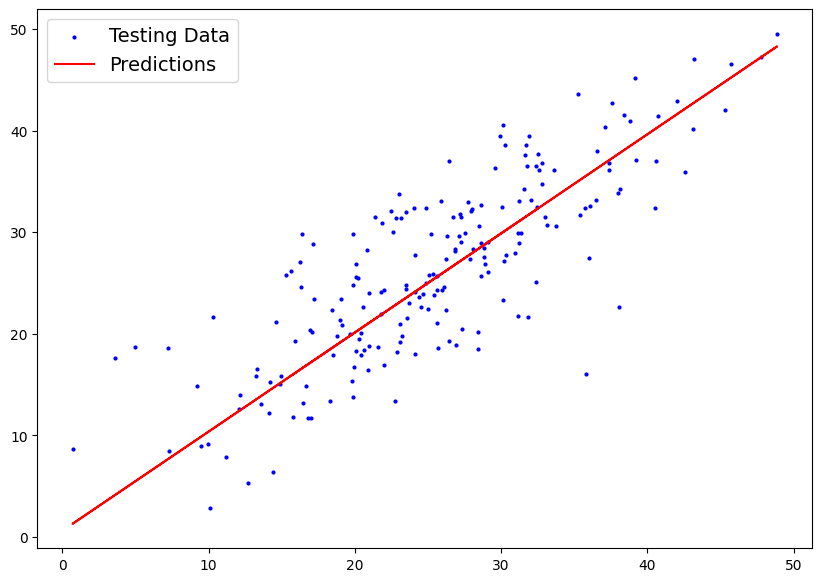

In [9]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)

plt.figure(figsize=(10, 7))

plt.scatter(X_test, y_test, c="b", s=4, label="Testing Data")
plt.plot(X_test, y_preds, c="r", label="Predictions")

plt.legend(prop={"size": 14})

## 7. Analyze the model's performance

We can plot the training loss at each epoch to see how it decreased with each iteration of the training loop

Final Training Loss: 4.227255344390869


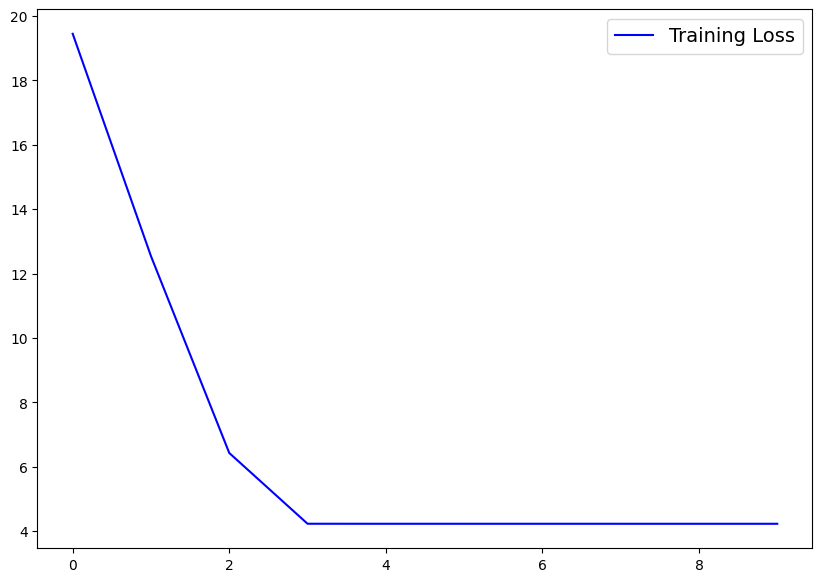

In [10]:
import numpy as np

plt.figure(figsize=(10, 7))

plt.plot(np.arange(0, 10), train_losses, c="b", label="Training Loss")

plt.legend(prop={"size": 14})

print(f"Final Training Loss: {train_losses[-1]}")

We can also calculate the mean average error (MAE or L1 loss) in order to understand by how many thousands of dollars our model's predictions, on average, will differ from the actual monthly salaries.

In [12]:
import torch.nn.functional as F

mae = F.l1_loss(y_test, y_preds).item()

print(f"MAE: {mae}")
print("Interpretation")
print(f"On average, this model's predictions for monthly salaries differ from the actual salaries by approximately ${round(mae * 1000)}")
print(f"We could expect the true yearly salary on average to be within ${round(mae * 1000) * 12} above or below the predicted value\n")

print("Some examples")
model.eval()
with torch.inference_mode():
  pred_12 = model(torch.Tensor([[12]]))
  print(f"Someone with 1 year of experience is predicted to earn ${round(pred_12.item() * 1000)} per month or ${round(pred_12.item() * 1000) * 12} per year. We could expect the true yearly salary to be between ${(round(pred_12.item() * 1000) * 12) - round(mae * 1000) * 12} and ${(round(pred_12.item() * 1000) * 12) + round(mae * 1000) * 12}")

  pred_24 = model(torch.Tensor([[24]]))
  print(f"Someone with 2 years of experience is predicted to earn ${round(pred_24.item() * 1000)} per month or ${round(pred_24.item() * 1000) * 12} per year. We could expect the true yearly salary to be between ${(round(pred_24.item() * 1000) * 12) - round(mae * 1000) * 12} and ${(round(pred_24.item() * 1000) * 12) + round(mae * 1000) * 12}")

MAE: 4.322385311126709
Interpretation
On average, this model's predictions for monthly salaries differ from the actual salaries by approximately $4322
We could expect the true yearly salary on average to be within $51864 above or below the predicted value

Some examples
Someone with 1 year of experience is predicted to earn $12325 per month or $147900 per year. We could expect the true yearly salary to be between $96036 and $199764
Someone with 2 years of experience is predicted to earn $24034 per month or $288408 per year. We could expect the true yearly salary to be between $236544 and $340272


Overall, I think that this model is helpful, but not strong. Having a range of around $100,000 in error on average for predicting a salary is a relatively large gap. However, it is not uncommon for people with the same level of experience to earn different salaries. Other factors may influence someone's salary, such as connections that lead them to a higher paying job, or a lack of available jobs that forces someone to take a lower salary. Because this model relies on only one feature, it cannot produce well-informed results. A prediction from this model may be useful as a starting point for negotiating a salary. The range of error can serve as a bounds for where the agreed upon salary should reasonably fall between.